In [1]:
import ROOT as r
import ctypes
import numpy as np

Welcome to JupyROOT 6.20/00


In [2]:
r.gSystem.Load("lib/libSANDGeoManager.so")

0

In [3]:
r.gInterpreter.ProcessLine('#include "include/utils.h"')
r.gSystem.Load("lib/libUtils.so")

0

In [4]:
f = r.TFile("../../prod-for-dev/muon-in-stt.edep-sim.root")
g = f.Get("EDepSimGeometry")

Info in <TGeoManager::CloseGeometry>: Geometry loaded from file...
Info in <TGeoManager::SetTopVolume>: Top volume is volWorld_PV. Master volume is volWorld_PV
Info in <TGeoNavigator::BuildCache>: --- Maximum geometry depth set to 100
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CountLevels>: max level = 23, max placements = 766
Info in <TGeoManager::CloseGeometry>: 1614047 nodes/ 6399 volume UID's in Simulated Detector Geometry
Info in <TGeoManager::CloseGeometry>: ----------------modeler ready----------------


In [5]:
sand_geo = r.SANDGeoManager()
sand_geo.init(g)

In [6]:
ecal = {"barrel": [], "endcapR": [], "endcapL": []}

detector_id = ctypes.c_int(0)
module_id = ctypes.c_int(0)
layer_id = ctypes.c_int(0)
cell_local_id = ctypes.c_int(0)

for item in sand_geo.get_ecal_cell_info():
    cell_global_id = item.first
    
    sand_geo.decode_ecal_cell_id(cell_global_id, detector_id, module_id, layer_id, cell_local_id)
    
    if detector_id.value == 1:
        ecal["endcapL"].append(item)
    elif detector_id.value == 3:
        ecal["endcapR"].append(item)
    elif detector_id.value == 2:
        ecal["barrel"].append(item)
    else:
        print(f"ERROR: unexpcted detector id: {detector_id.value}")    

In [7]:
def draw_ecal_subdetector(detector_name):
    n = len(ecal[detector_name])
    gr_xz = r.TGraph(n)
    gr_yz = r.TGraph(n)
    gr_yx = r.TGraph(n)
    for index, item in enumerate(ecal[detector_name]):
        cell_info = item.second
        gr_xz.SetPoint(index, cell_info.z(), cell_info.x())
        gr_yz.SetPoint(index, cell_info.z(), cell_info.y())
        gr_yx.SetPoint(index, cell_info.x(), cell_info.y())

    c = r.TCanvas("","",1500,500)
    c.Divide(3,1)
    c.cd(1)
    gr_xz.Draw("a*")
    c.cd(2)
    gr_yz.Draw("a*")
    c.cd(3)
    gr_yx.Draw("a*")
    return {"canvas": c, "gr_xz": gr_xz, "gr_yz": gr_yz, "gr_yx": gr_yx}

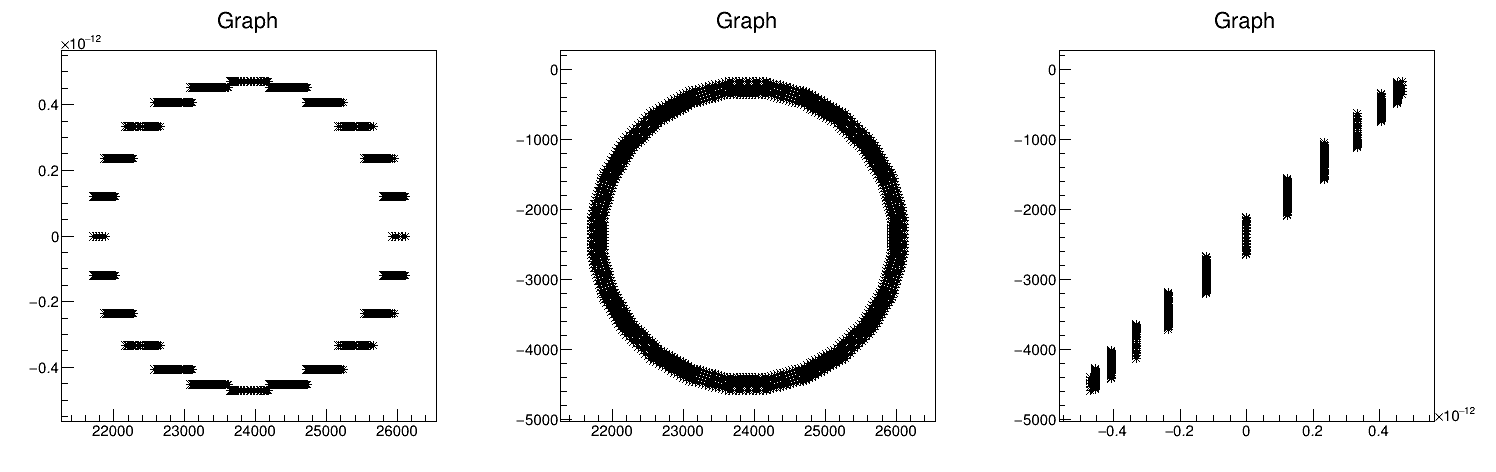

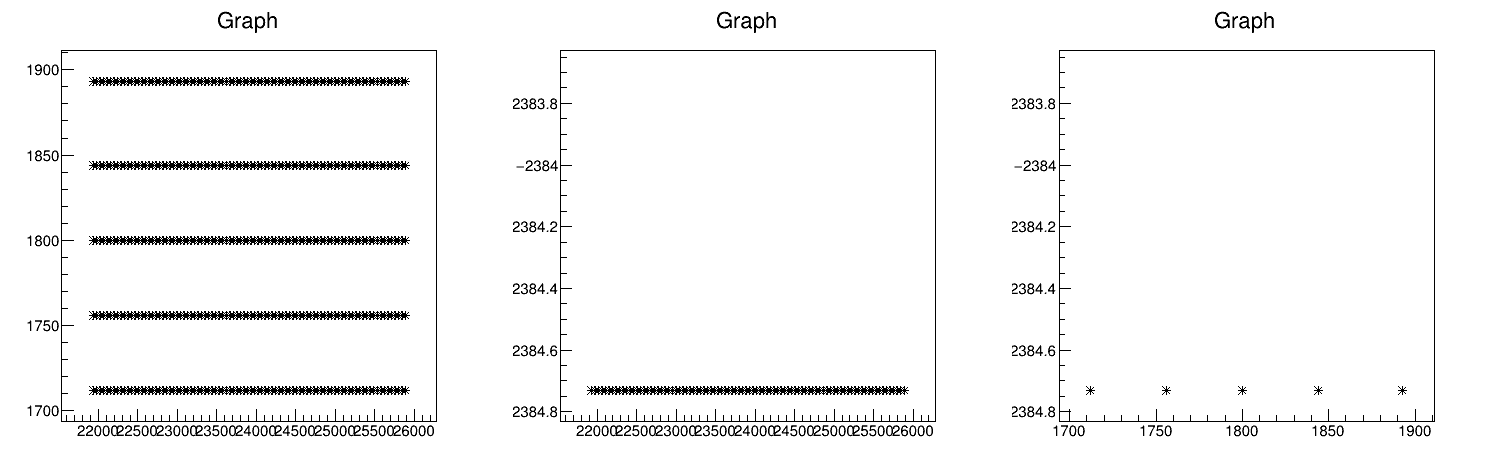

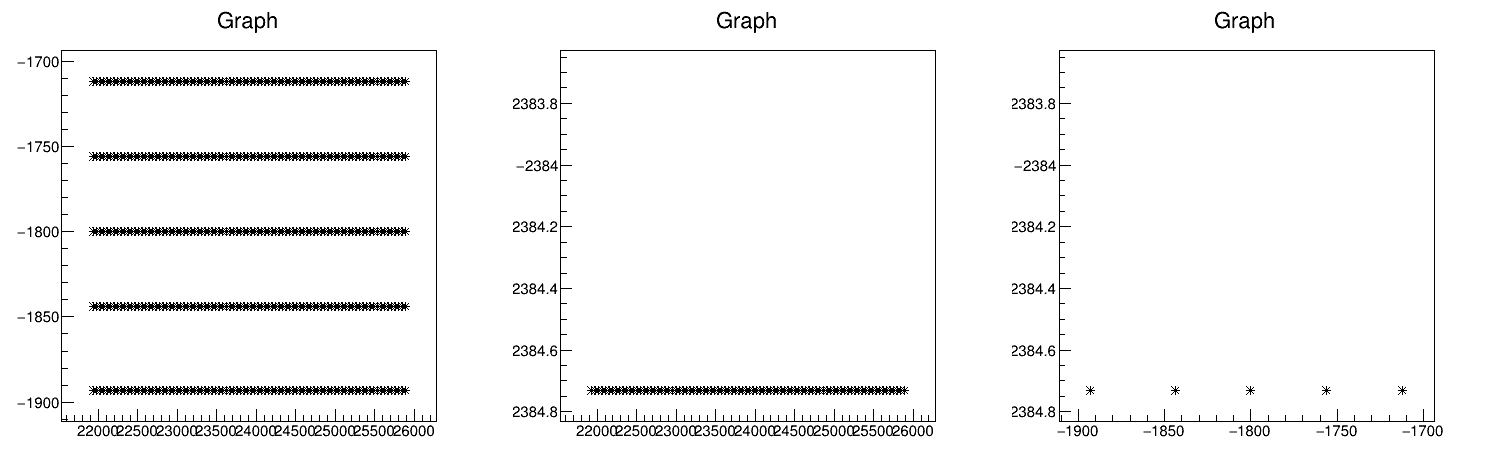

In [8]:
items = []
for subdetector in ecal:
    item = draw_ecal_subdetector(subdetector)
    item["canvas"].Draw()
    items.append(item)

In [9]:
stt = {"horizontal": [], "vertical": []}

module_id = ctypes.c_int(0)
plane_global_id = ctypes.c_int(0)
plane_local_id = ctypes.c_int(0)
plane_type = ctypes.c_int(0)
tube_local_id = ctypes.c_int(0)

for item in sand_geo.get_stt_tube_info():
    tube_gloabl_id = item.first
    
    sand_geo.decode_stt_tube_id(tube_gloabl_id, plane_global_id, tube_local_id)
    sand_geo.decode_stt_plane_id(plane_global_id.value, module_id, plane_local_id, plane_type)
    
    if plane_type.value == 2:
        stt["horizontal"].append(item)
    elif plane_type.value == 1:
        stt["vertical"].append(item)
    else:
        print(f"ERROR: unexpcted plane type: {plane_type.value}")   

In [10]:
def draw_stt_type(stt_type):
    n = len(stt[stt_type])
    gr_xz = r.TGraph(n)
    gr_yz = r.TGraph(n)
    gr_yx = r.TGraph(n)
    for index, item in enumerate(stt[stt_type]):
        stt_info = item.second
        gr_xz.SetPoint(index, stt_info.z(), stt_info.x())
        gr_yz.SetPoint(index, stt_info.z(), stt_info.y())
        gr_yx.SetPoint(index, stt_info.x(), stt_info.y())

    c = r.TCanvas("","",1500,500)
    c.Divide(3,1)
    c.cd(1)
    gr_xz.Draw("a*")
    c.cd(2)
    gr_yz.Draw("a*")
    c.cd(3)
    gr_yx.Draw("a*")
    return {"canvas": c, "gr_xz": gr_xz, "gr_yz": gr_yz, "gr_yx": gr_yx}

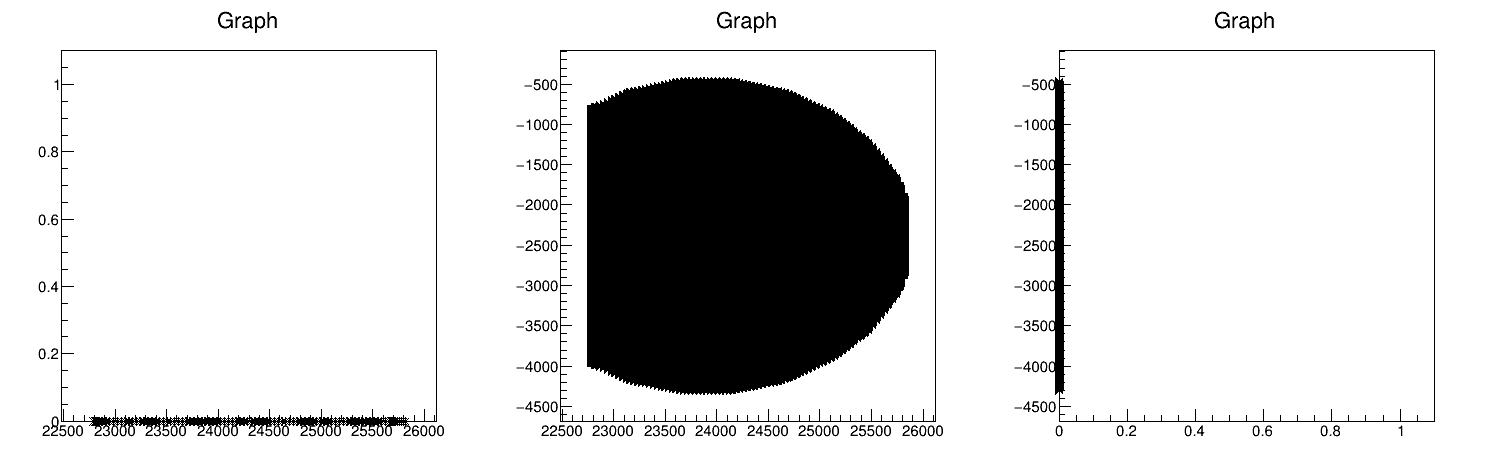

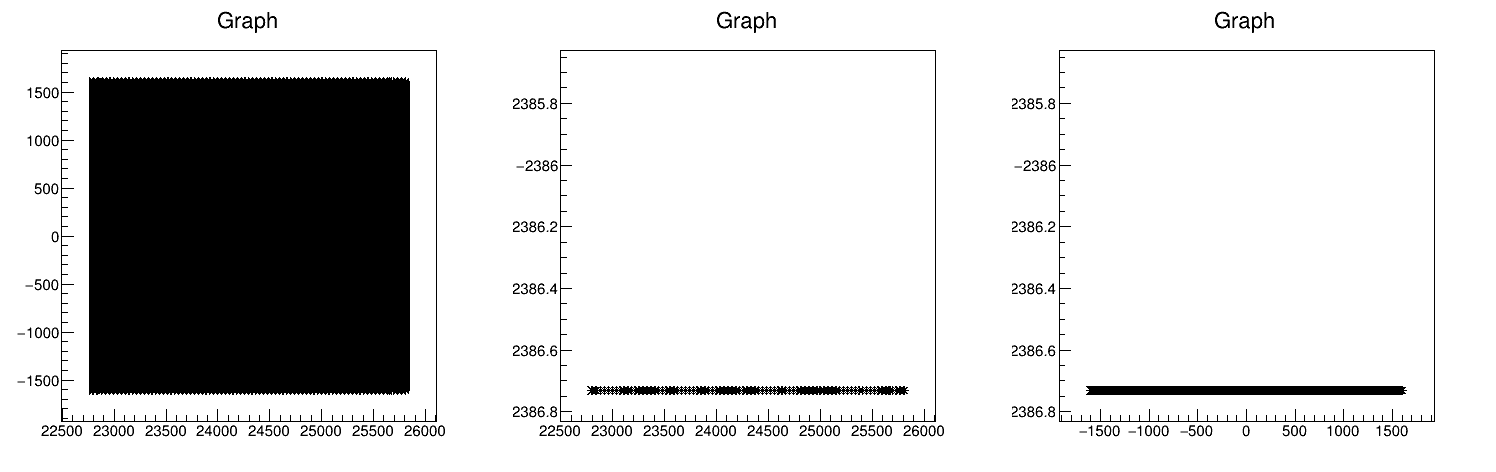

In [11]:
items = []
for stt_type in stt:
    item = draw_stt_type(stt_type)
    item["canvas"].Draw()
    items.append(item)

In [ ]:
r.sand_reco.init(g)

In [ ]:
for item in r.sand_reco.stt.tubePos:
    tube_id = item.first
    tube_position = item.second
    tube_info = sand_geo.get_stt_tube_info(tube_id)
    tube_longitudinal_coord = tube_info.z()
    tube_transversal_coord = tube_info.y() if tube_info.orientation() == r.SANDSTTTubeInfo.Orient.kHorizontal else tube_info.x()
    if tube_position.X() != tube_longitudinal_coord:
        print(f"ERROR: tube with ID: {tube_id} has different longitudinal coord. {tube_position.X()} <-> {tube_longitudinal_coord}")
    if tube_position.Y() != tube_transversal_coord:
        print(f"ERROR: tube with ID: {tube_id} has different transverse coord. {tube_position.Y()} <-> {tube_transversal_coord}")

In [ ]:
module_ids = [i for i in range(24)]
module_ids.append(30)
module_ids.append(40)

detector_ids = [2 for i in range(24)]
detector_ids.append(3)
detector_ids.append(1)

layer_ids = [i for i in range(5)]
cell_local_ids = [i for i in range(12)]

cell_x = ctypes.c_double(0.)
cell_y = ctypes.c_double(0.)
cell_z = ctypes.c_double(0.)

for index, module_id in enumerate(module_ids):
    detector_id = detector_ids[index]
    for layer_id in layer_ids:
        for cell_local_id in cell_local_ids:
            cell_global_id = r.sand_reco.ecal.decoder.EncodeID(detector_id, module_id, layer_id, cell_local_id)
            cell_info = sand_geo.get_ecal_cell_info(cell_global_id)
            
            r.sand_reco.ecal.geometry.CellPosition(g, detector_id, module_id, layer_id, cell_local_id, cell_x, cell_y, cell_z)
            
            if cell_x.value != cell_info.x():
                print(f"ERROR: cell with ID: {cell_global_id} has different X coord. {cell_x.value} <-> {cell_info.x()}")
            if cell_y.value != cell_info.y():
                print(f"ERROR: cell with ID: {cell_global_id} has different X coord. {cell_y.value} <-> {cell_info.y()}")
            if cell_z.value != cell_info.z():
                print(f"ERROR: cell with ID: {cell_global_id} has different X coord. {cell_z.value} <-> {cell_info.z()}")